In [1]:
import glob
from tqdm import tqdm
import uproot
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
plt.rcParams.update({"figure.facecolor": (1,1,1,0)})
import yahist
import mplhep as hep
plt.style.use(hep.style.CMS)

from scipy.optimize import curve_fit

 18%|███████████████████████████████████▎                                                                                                                                                            | 115/625 [00:02<00:10, 47.64it/s]/tmp/ipykernel_2902576/3818401014.py:30: RuntimeWarning: invalid value encountered in log
  curve = lambda x, A, B, C: A*np.log(x + B) + C
 20%|██████████████████████████████████████▍                                                                                                                                                         | 125/625 [00:02<00:11, 43.20it/s]/tmp/ipykernel_2902576/3818401014.py:30: RuntimeWarning: invalid value encountered in log
  curve = lambda x, A, B, C: A*np.log(x + B) + C
 22%|███████████████████████████████████████████                                                                                                                                                     | 140/625 [00:03<00:10, 45.43it/s]/tmp/ipykernel_2902576/381840

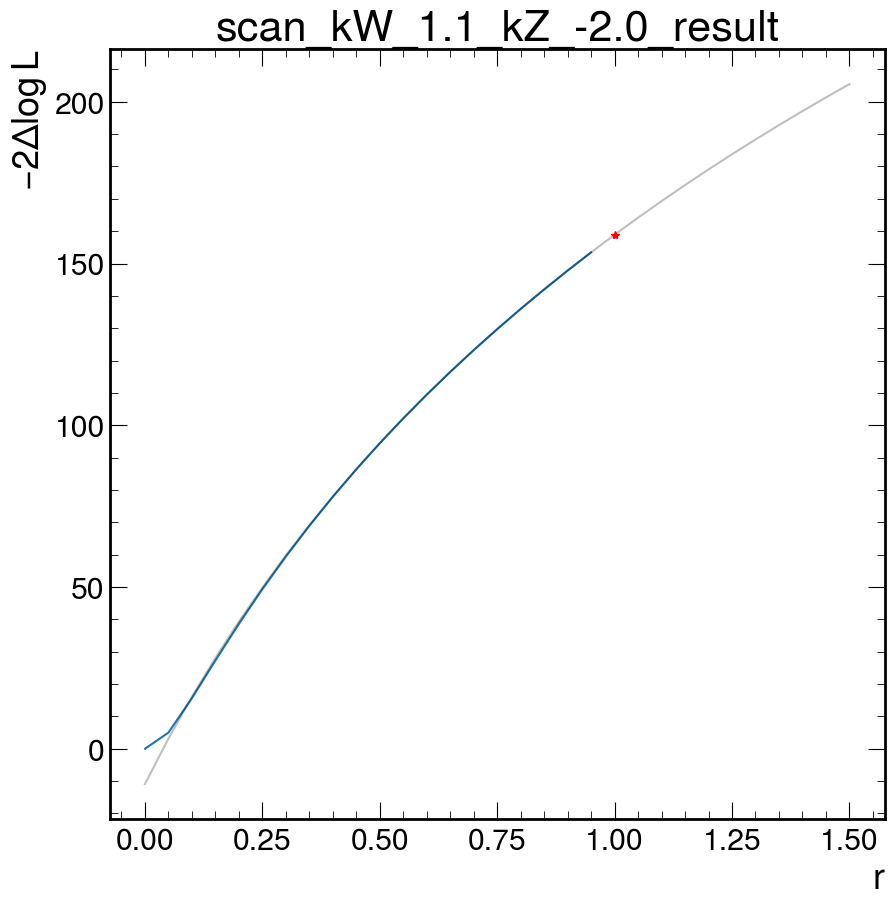

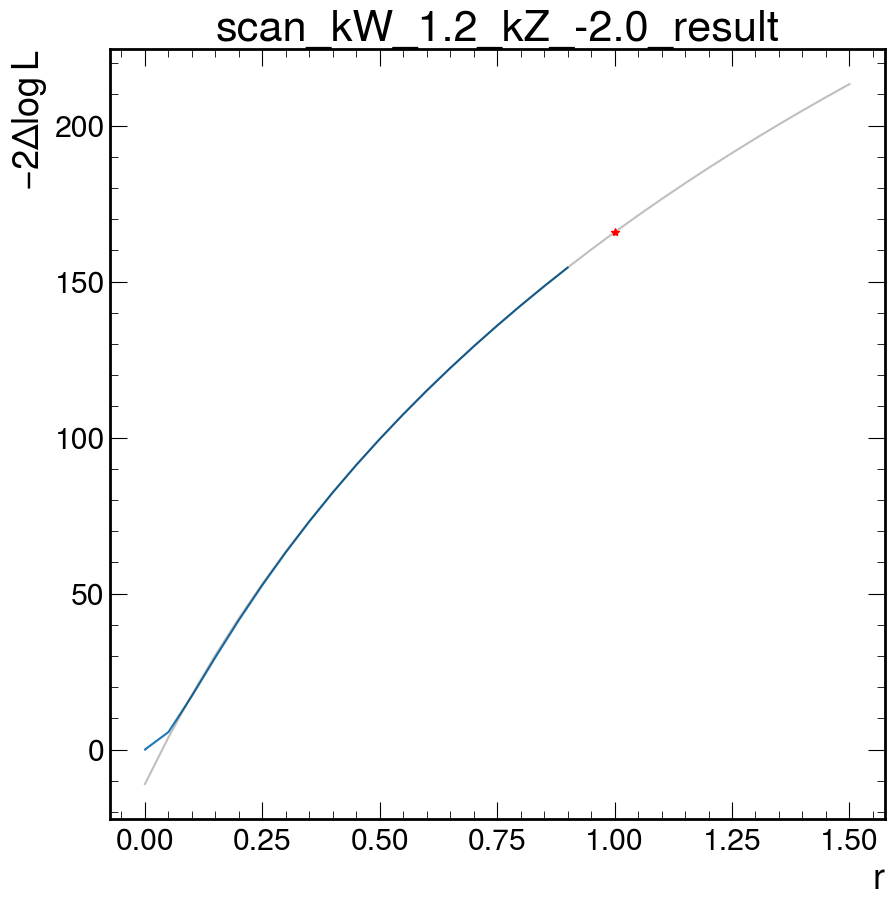

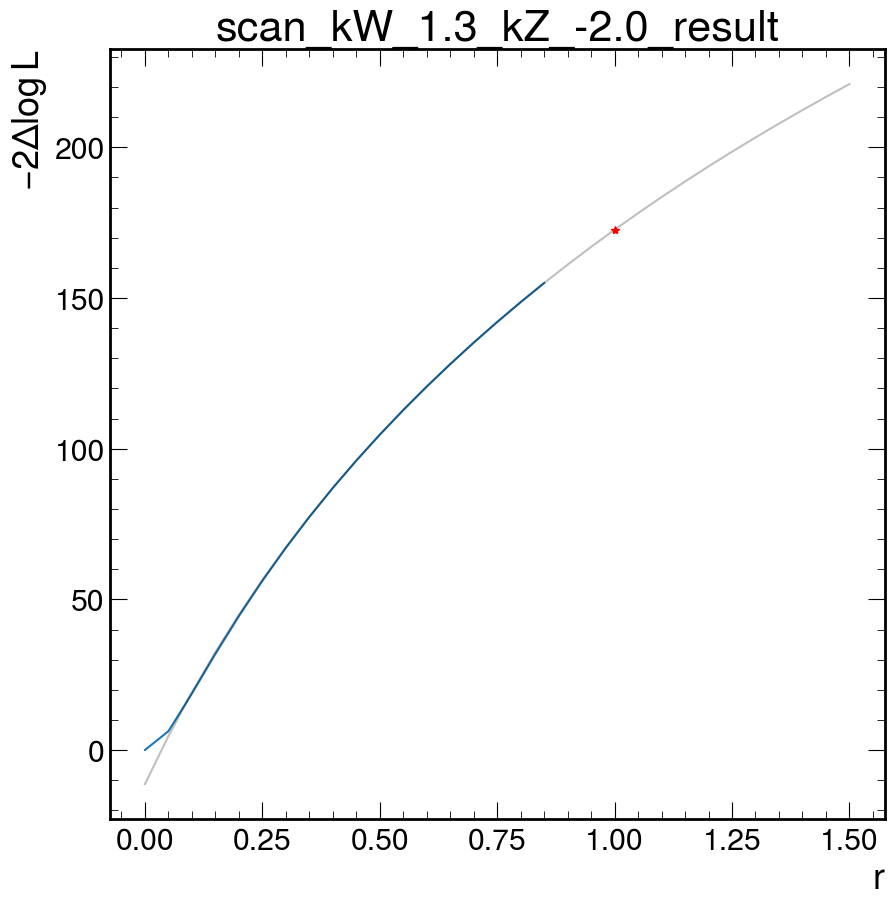

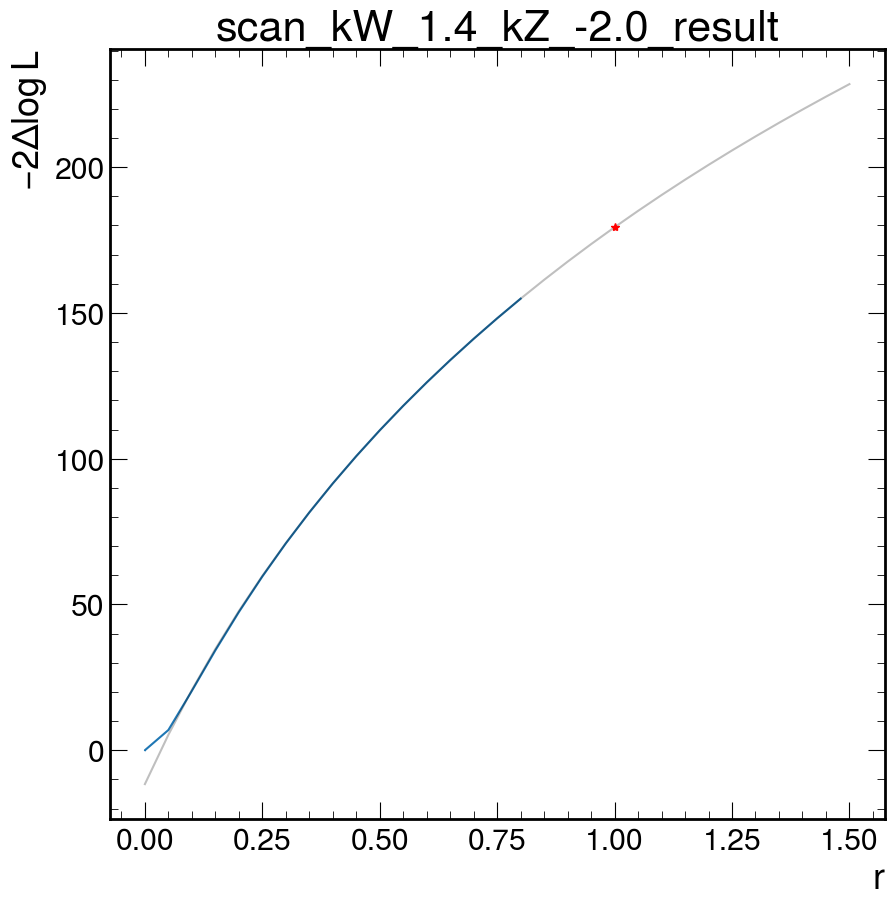

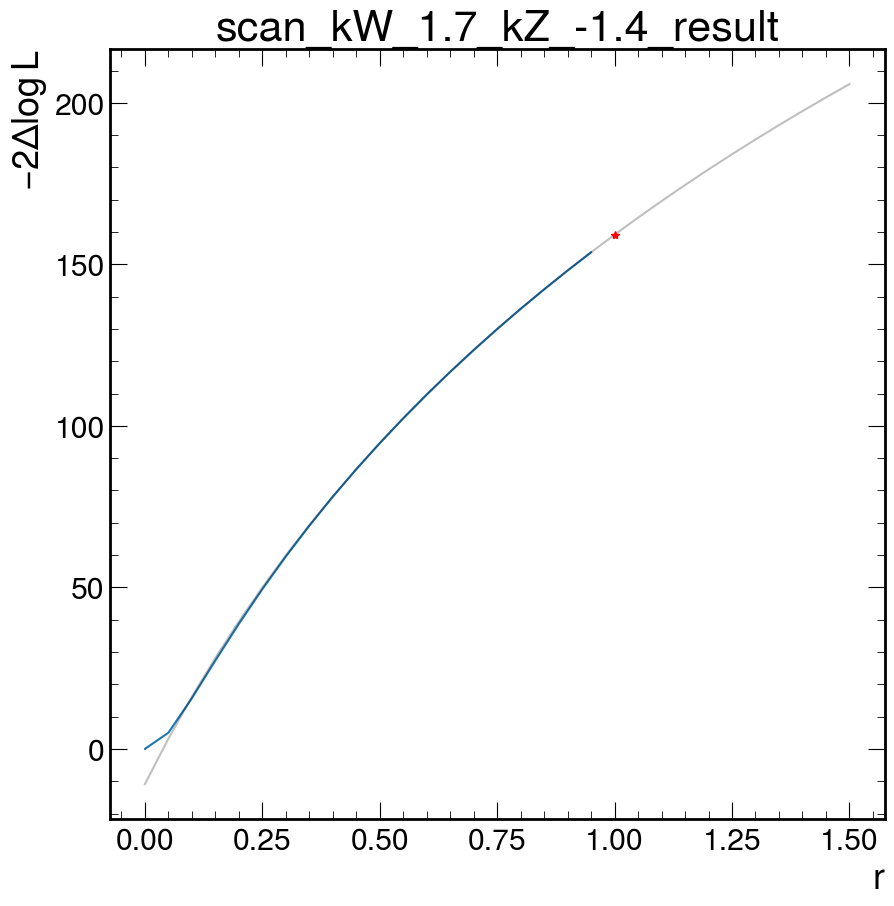

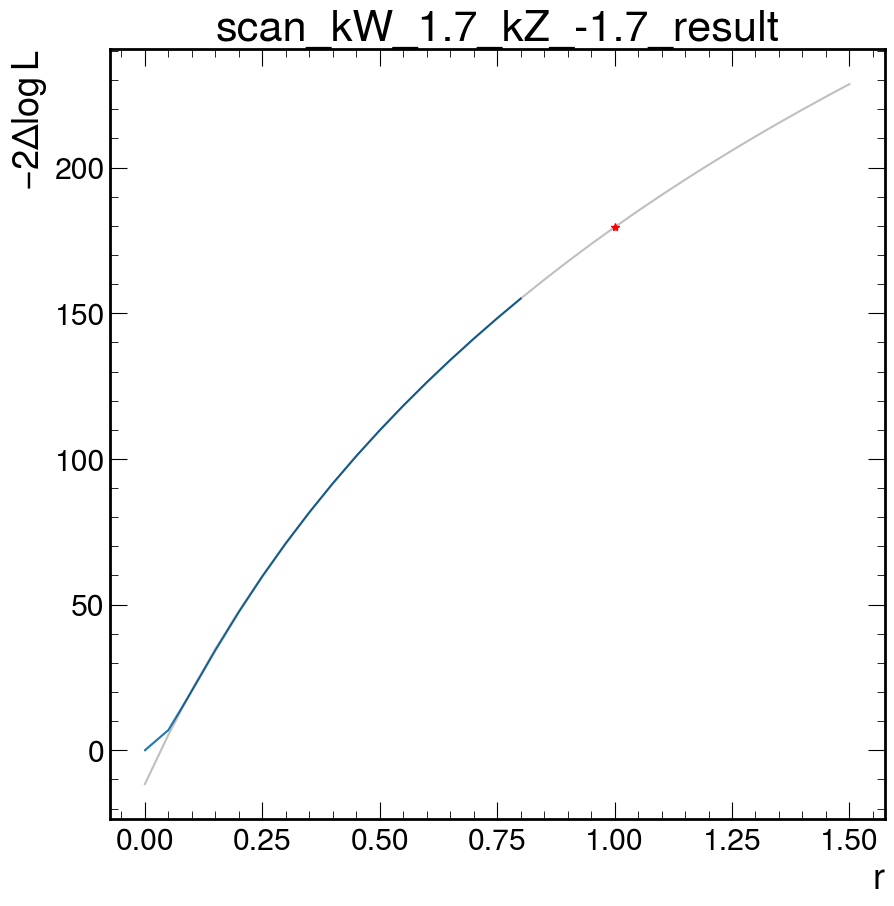

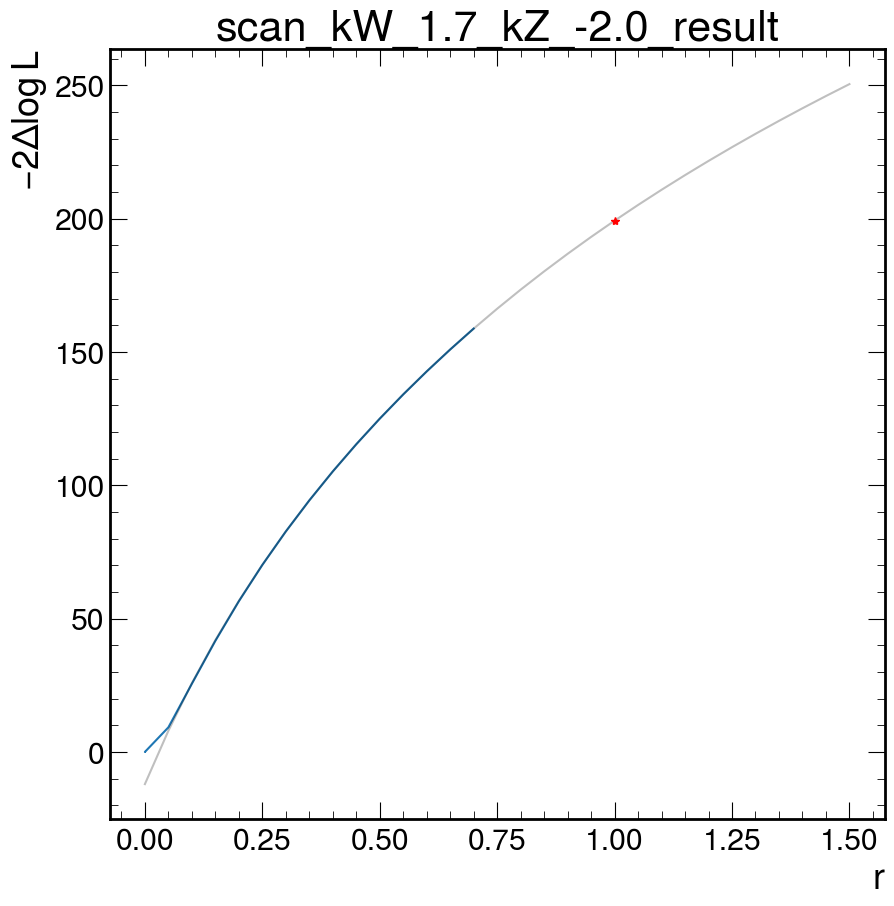

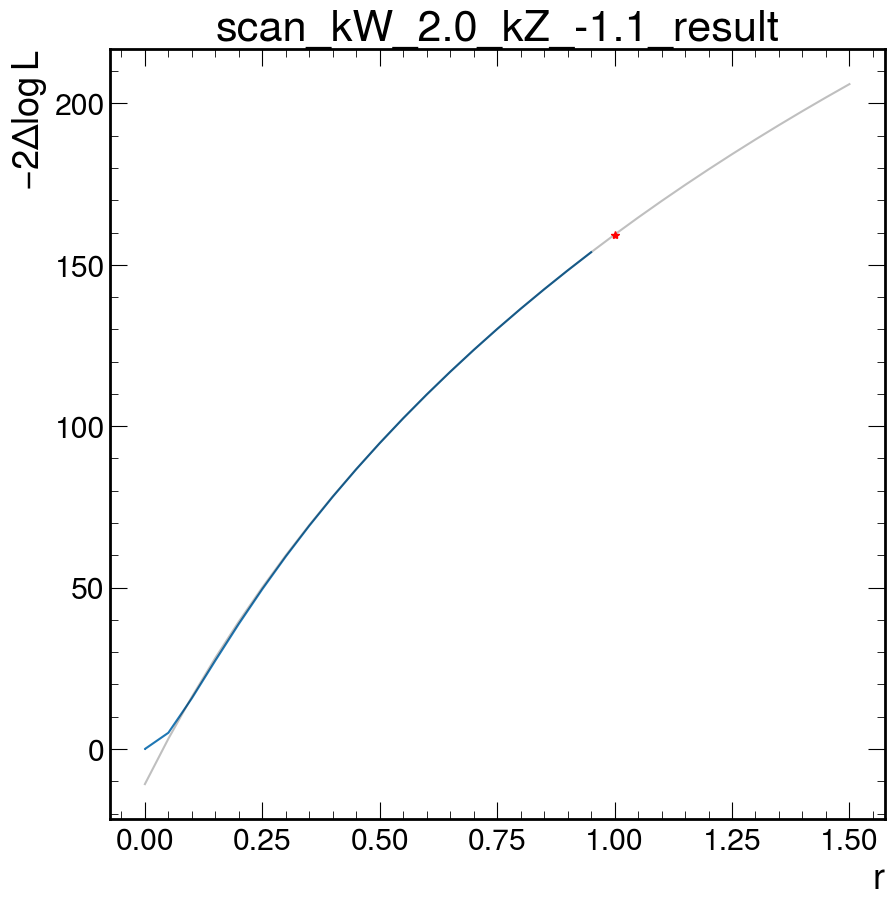

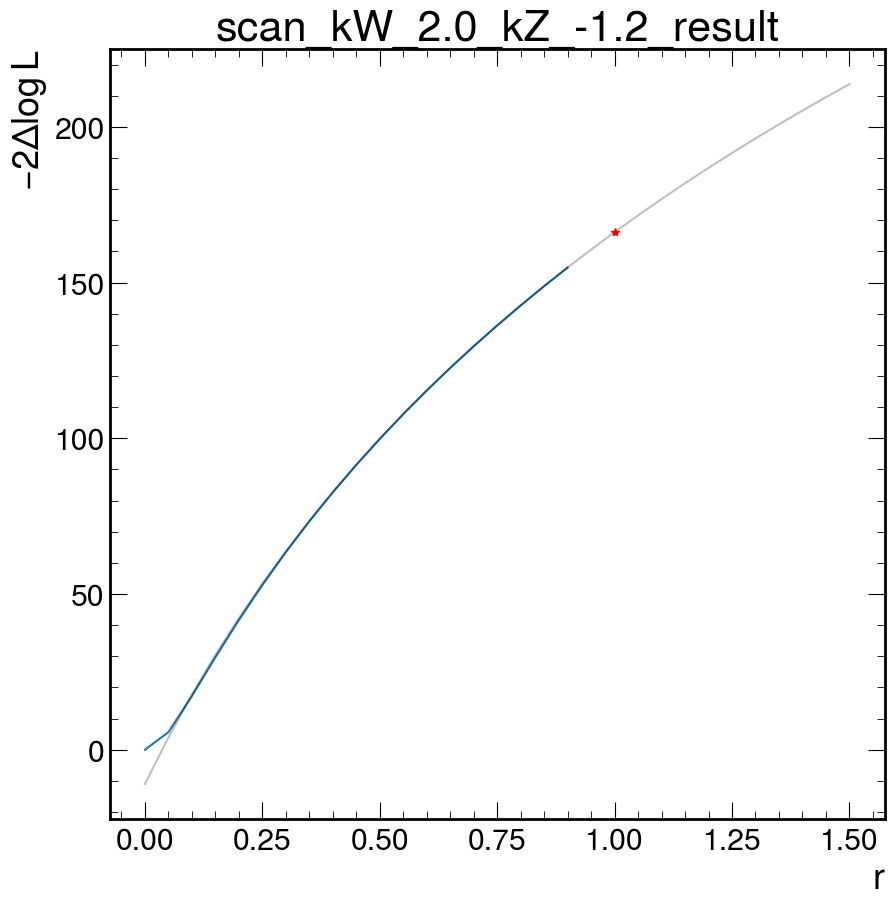

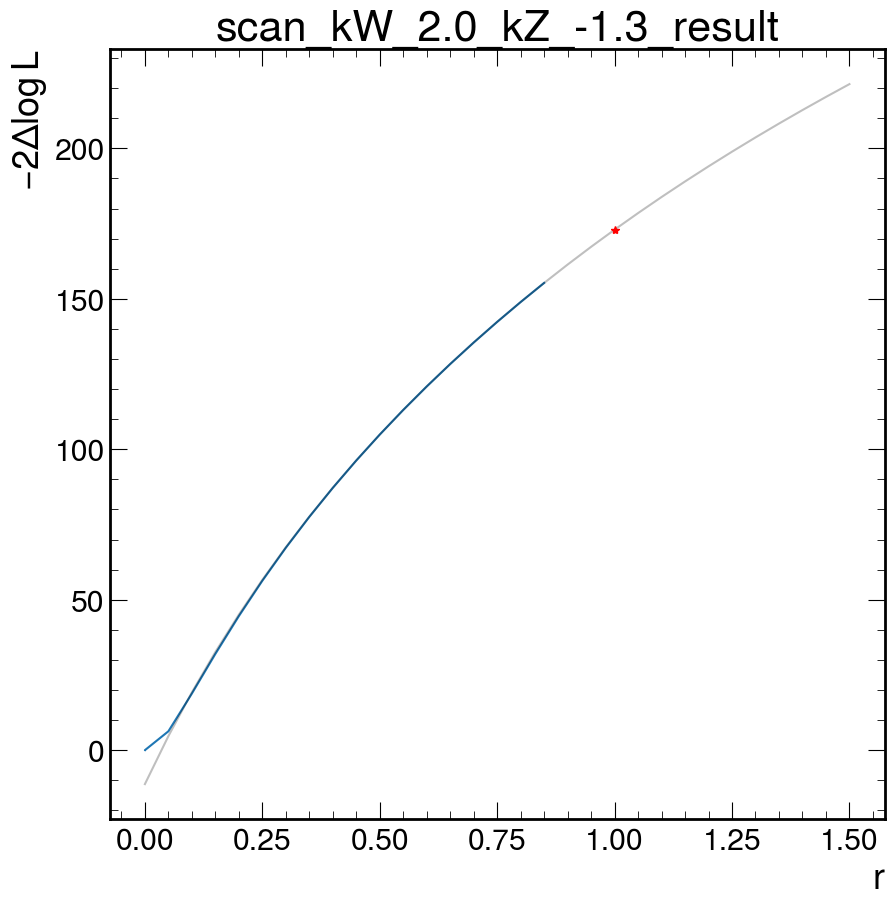

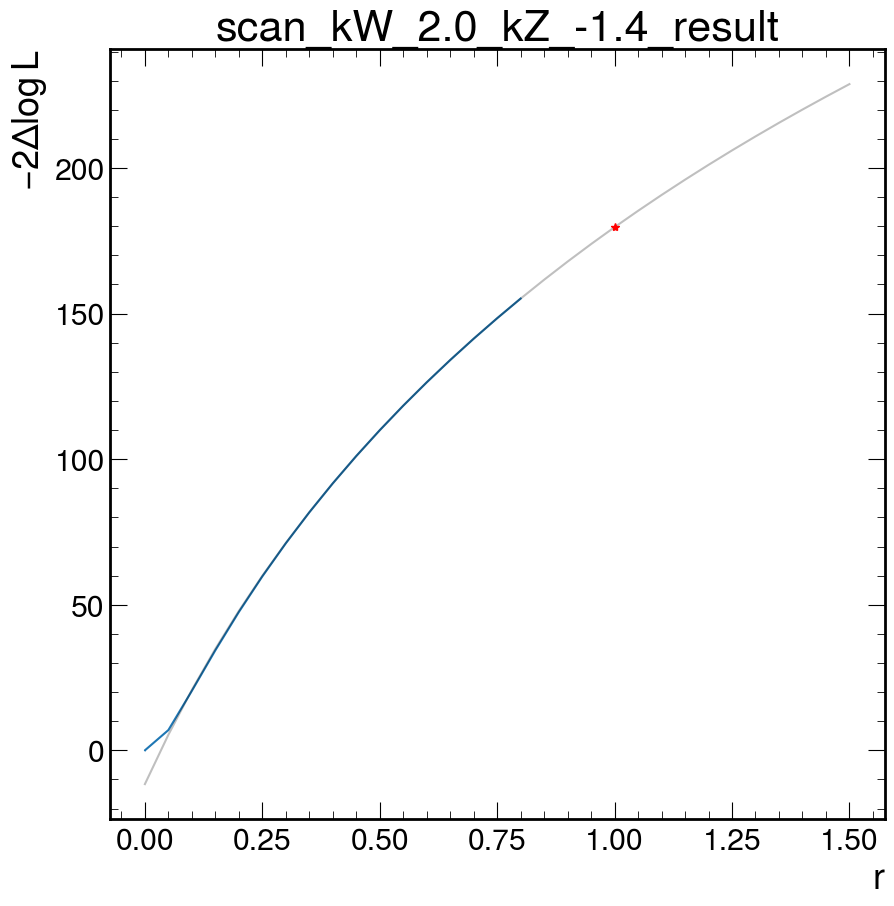

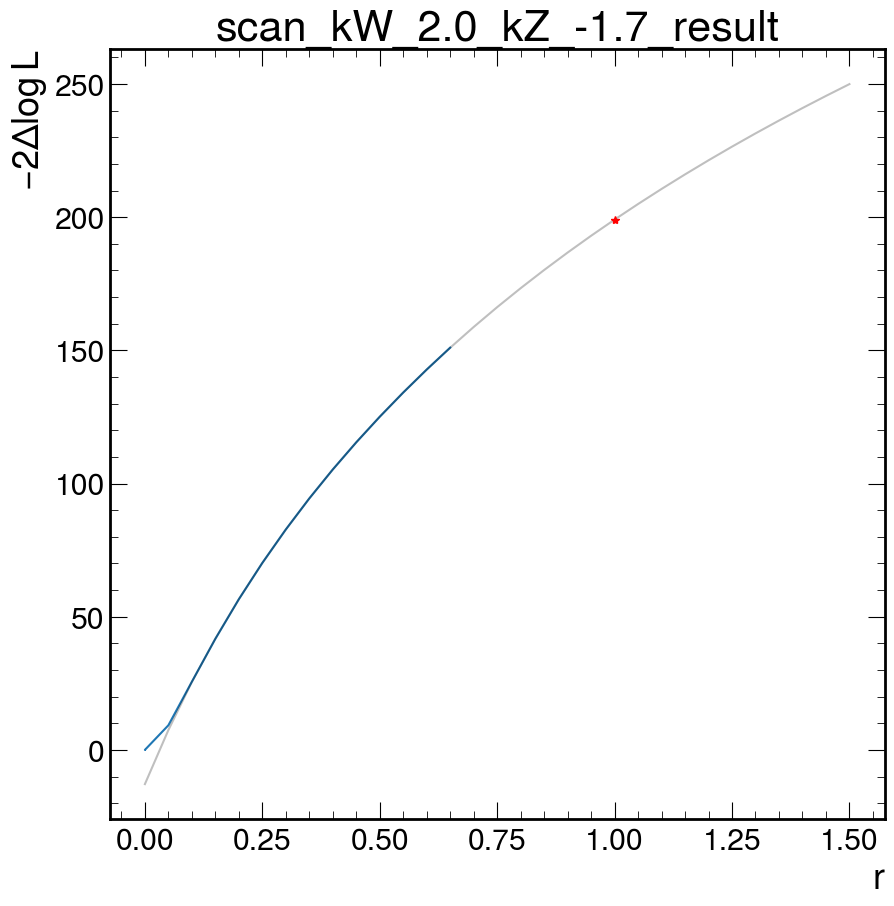

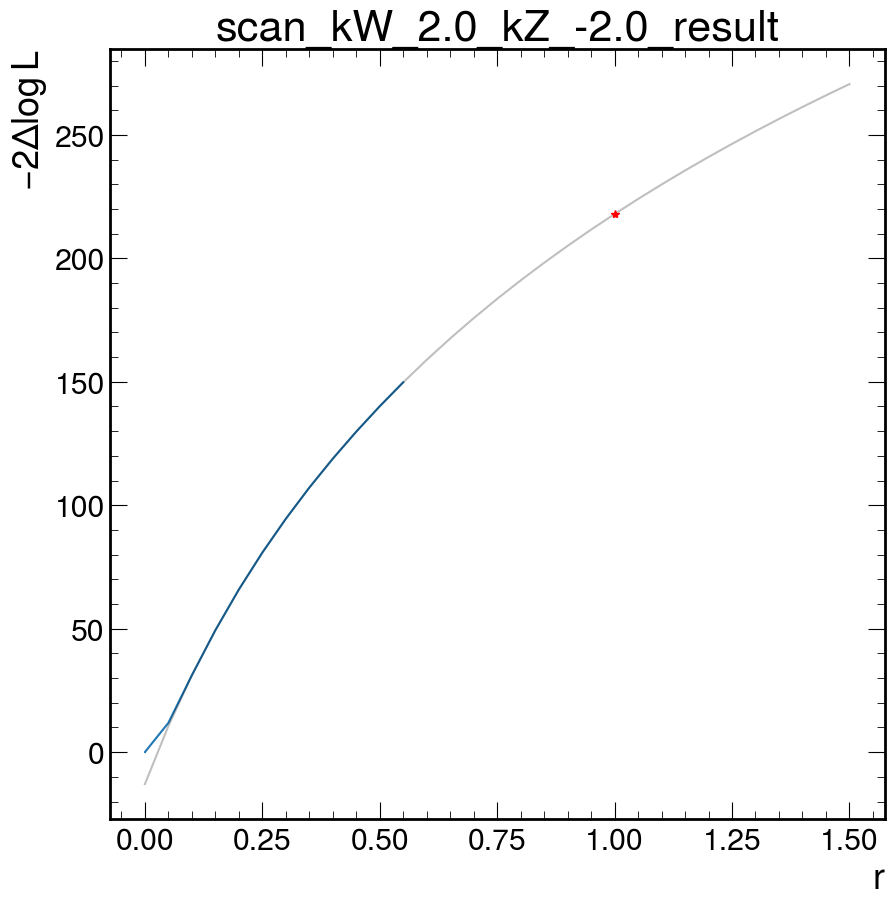

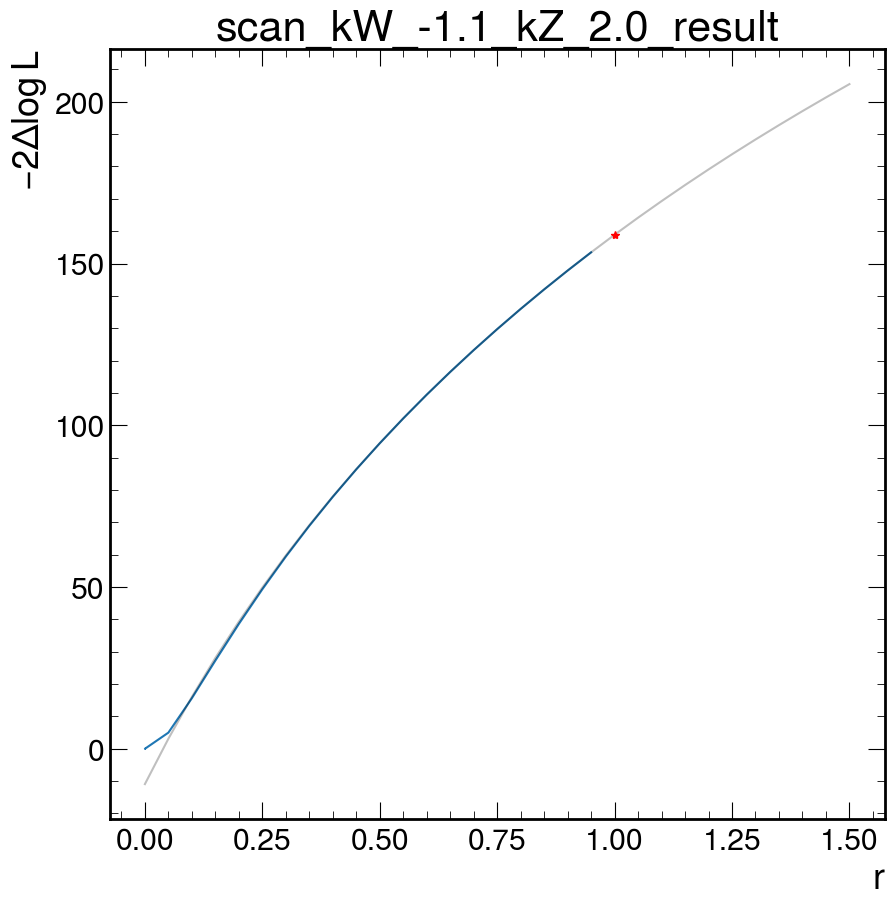

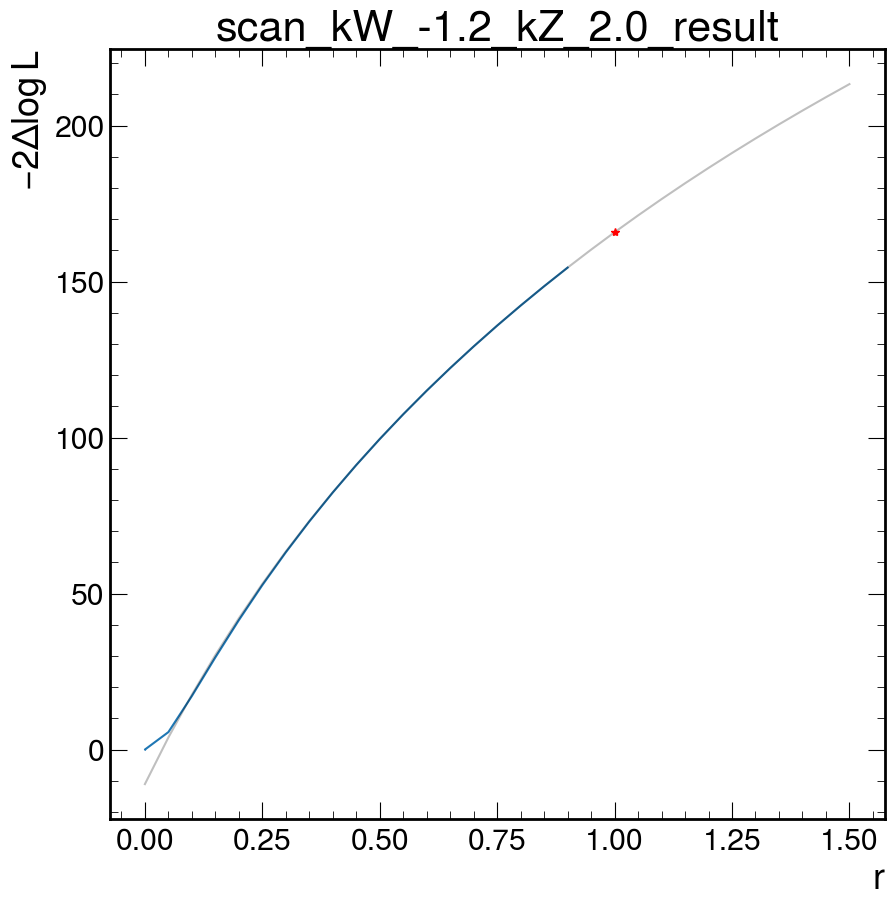

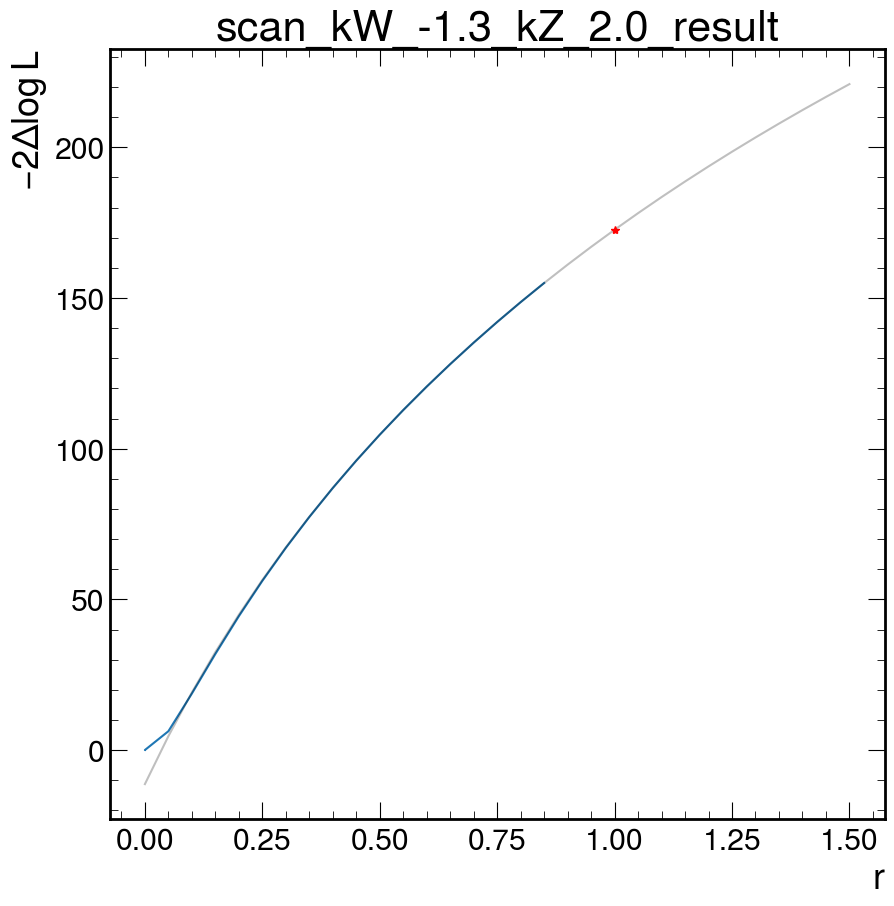

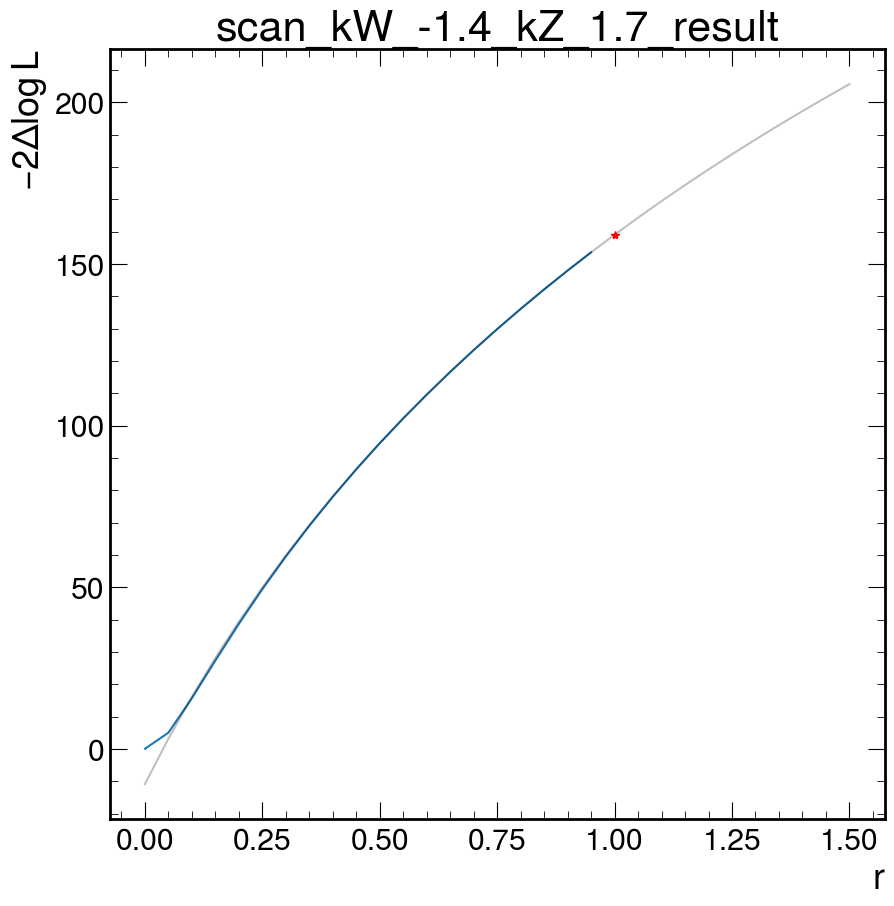

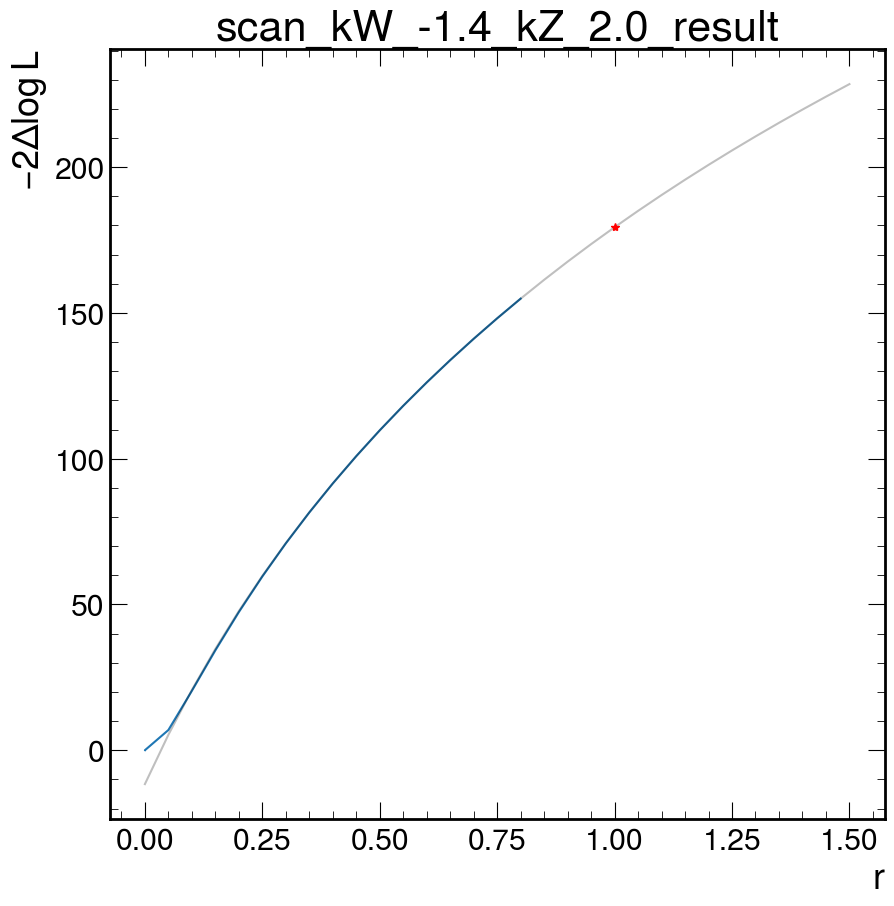

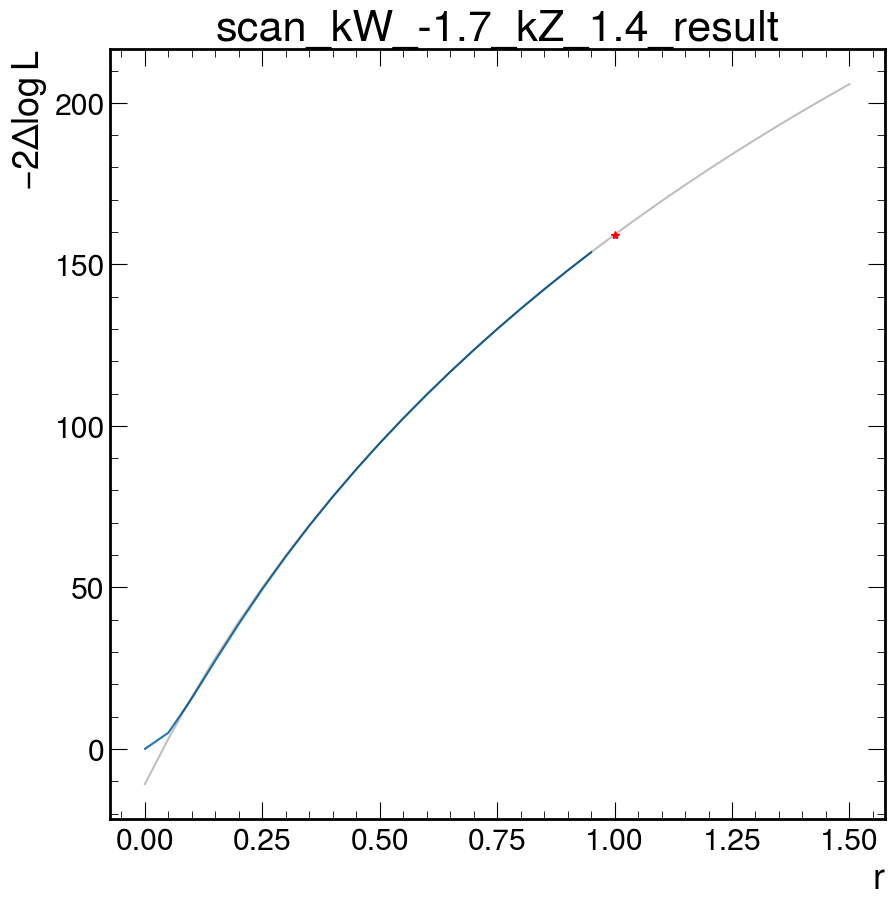

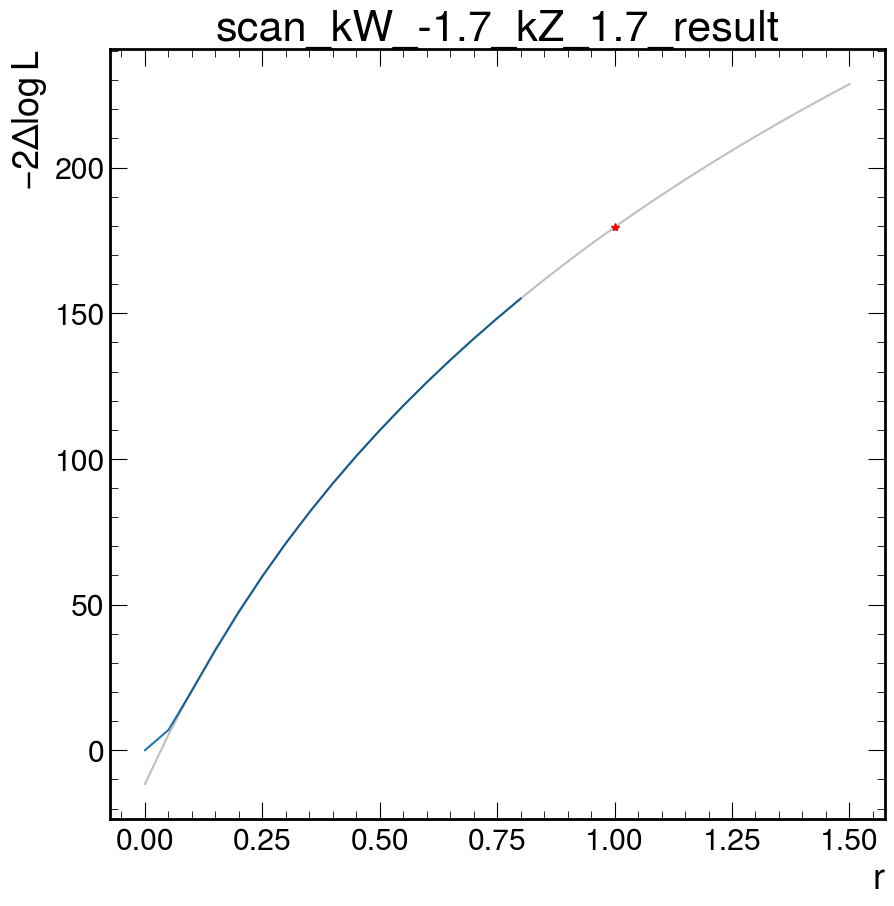

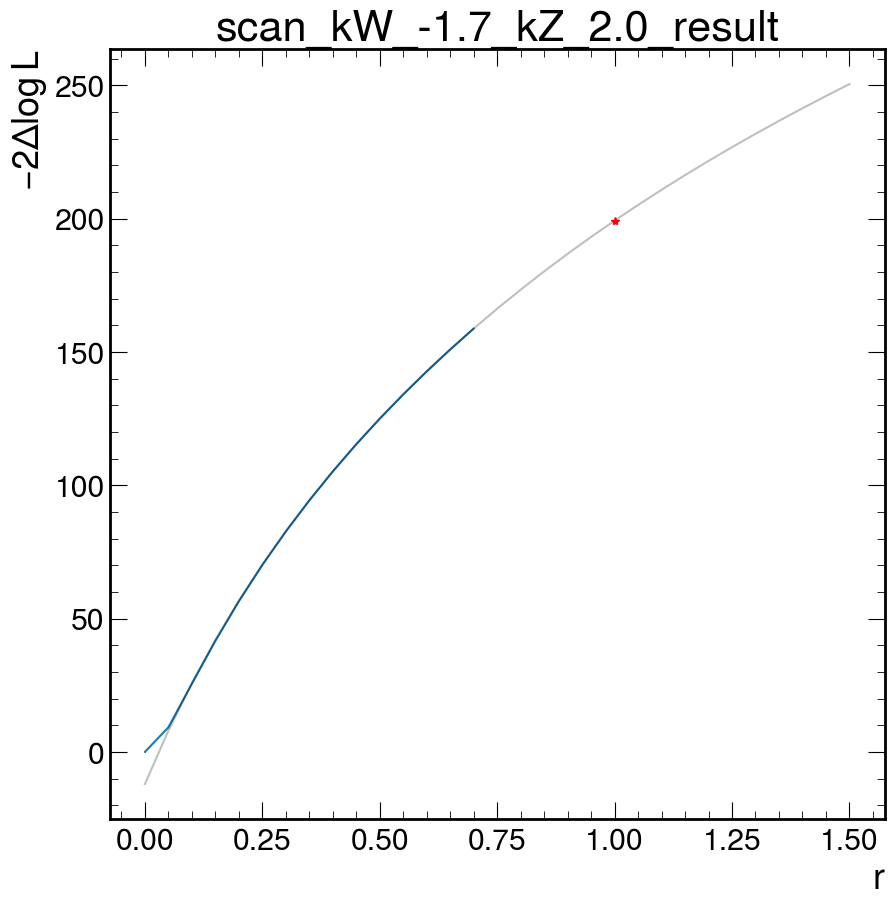

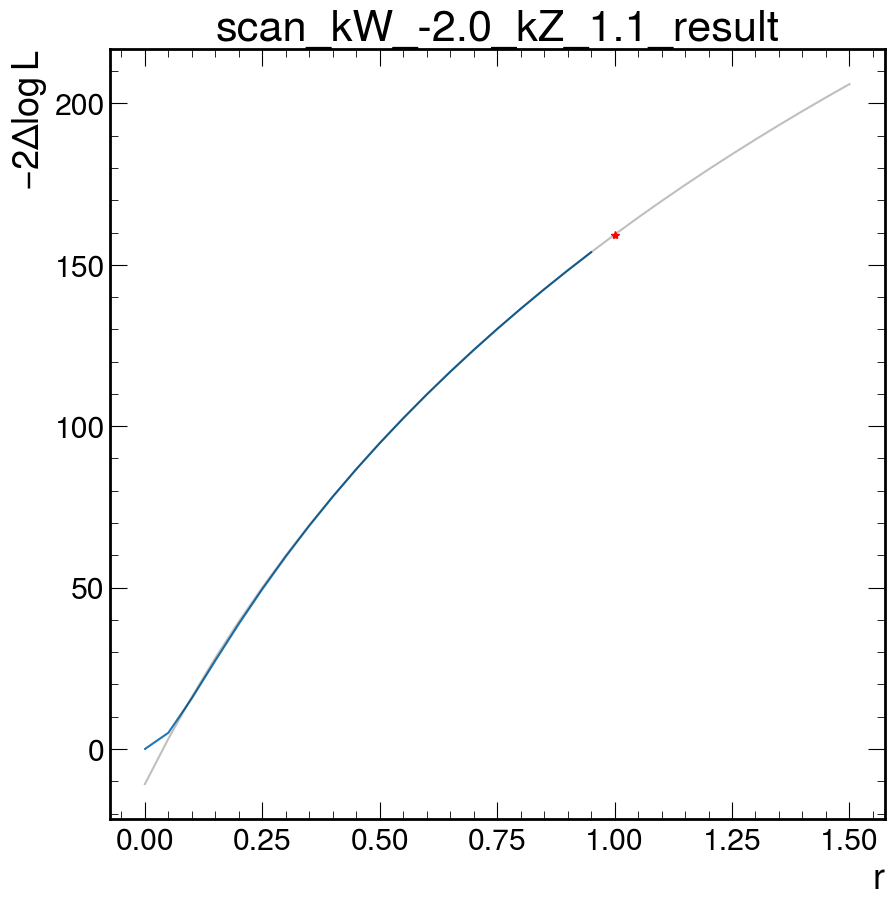

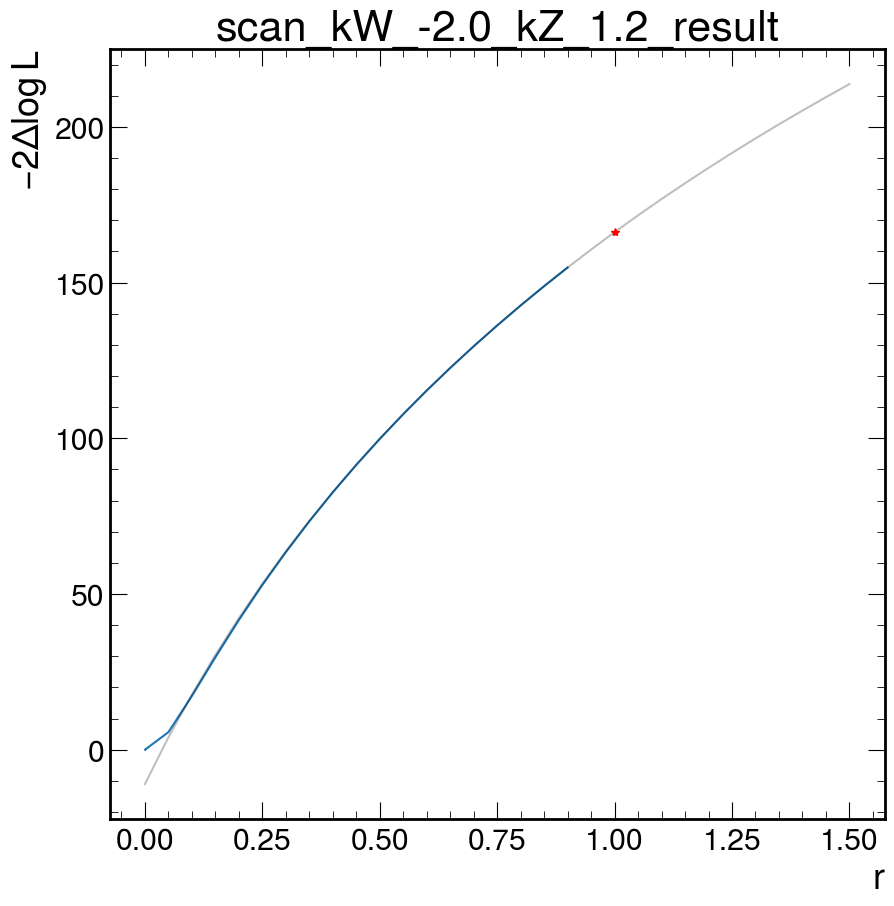

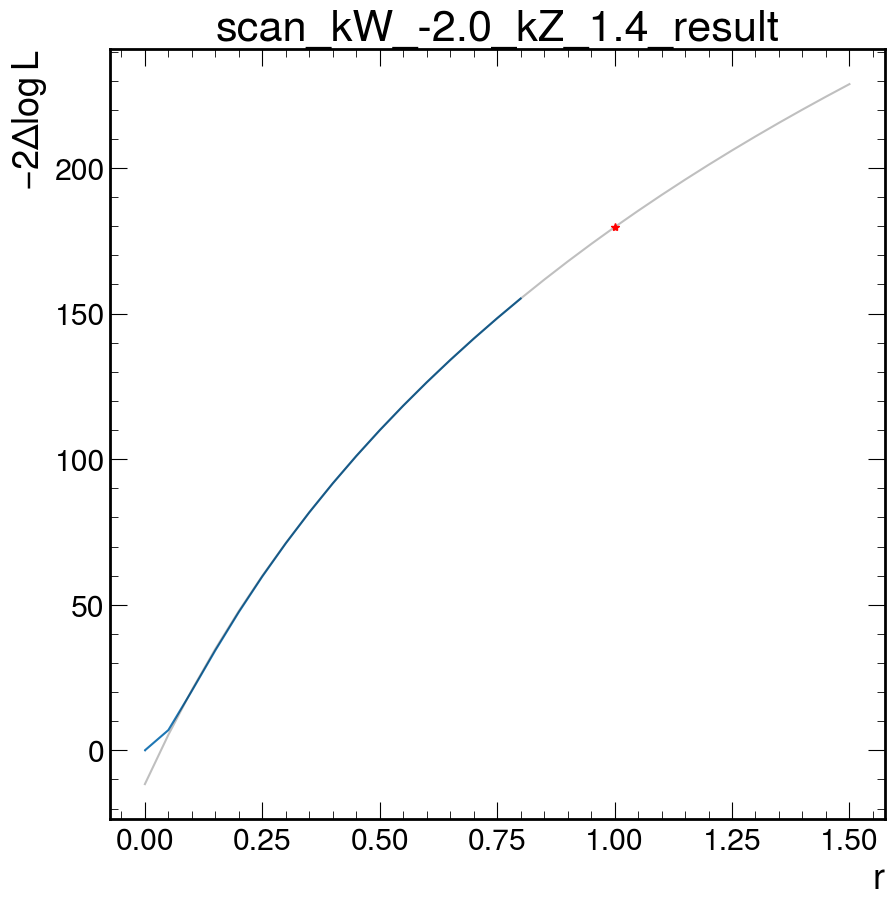

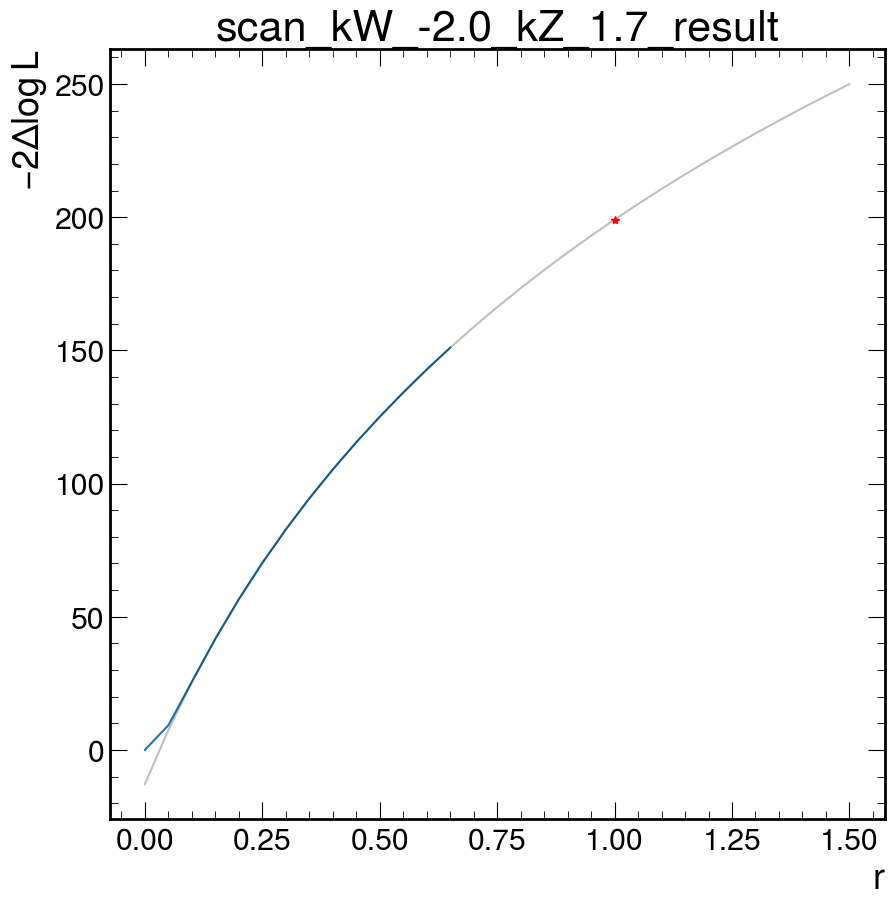

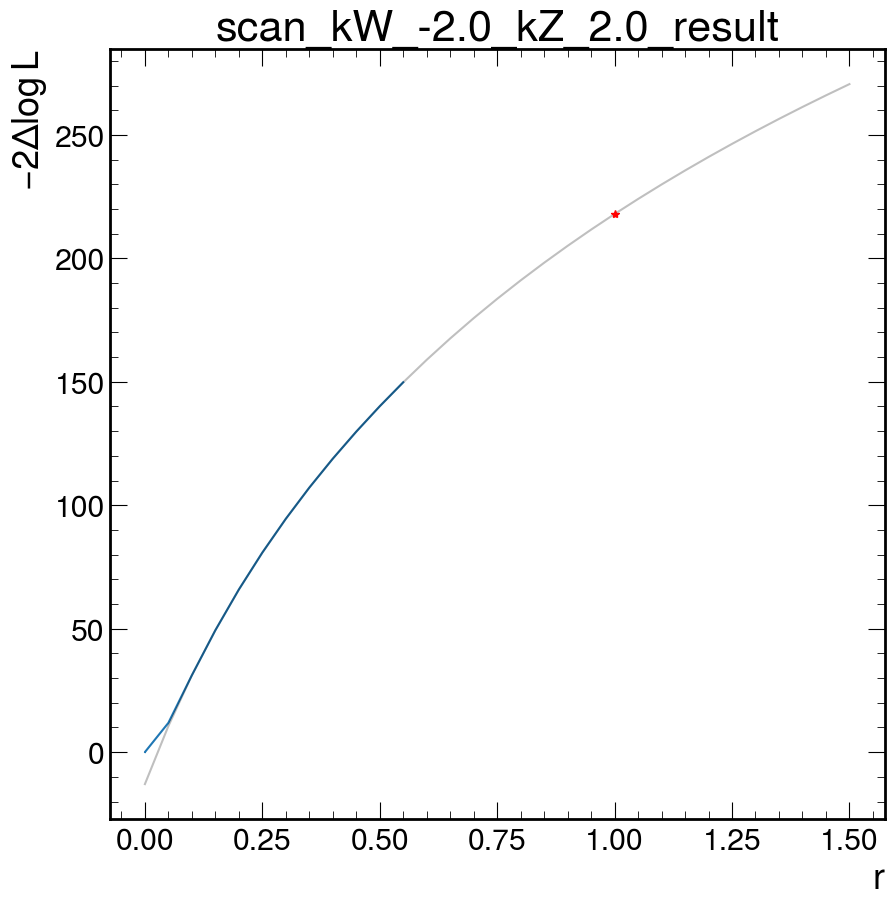

In [2]:
r_eq_1_sigmas = []
kW_points = []
kZ_points = []
kW_spec_points = []
kZ_spec_points = []
for combine_root_file in tqdm(glob.glob("../combine/results/*.root")):
    with uproot.open(combine_root_file) as f:
        points = f.get("limit").arrays(["r", "deltaNLL"], library="np")
        points["deltaNLL"] *= 2
        
    scan_name = combine_root_file.split("/")[-1].replace("m", "-").replace("p", ".").replace(".root", "")
    kW_points.append(float(scan_name.split("_")[2]))
    kZ_points.append(float(scan_name.split("_")[4]))

    r_eq_1_indices = np.where(points["r"] == 1)[0]
    if r_eq_1_indices.size == 0 or np.isnan(points["deltaNLL"][r_eq_1_indices[0]]):
        # Find largest exclusion value (ignore NaNs)
        max_excl_sigma_idx = np.nanargmax(points["deltaNLL"])
        max_excl_sigma = np.sqrt(points["deltaNLL"][max_excl_sigma_idx])
        if max_excl_sigma >= 2 and points["r"][max_excl_sigma_idx] < 1:
            # If the max exclusion is >= 2sigma and the corresponding r-value is less than one, then
            # the r-value of 1 is certainly excluded at some large value
#             r_eq_1_sigmas.append(10)
            
            # Plot original curve
            fig, axes = plt.subplots()
            nans = np.isnan(points["deltaNLL"])
            axes.plot(points["r"][~nans], points["deltaNLL"][~nans])
            # Fit last 10 points to a log
            curve = lambda x, A, B, C: A*np.log(x + B) + C
            opt_params, _ = curve_fit(curve, points["r"][~nans][-10:], points["deltaNLL"][~nans][-10:])
            # Plot best fit
            axes.plot(
                np.linspace(0, 1.5, 31), [curve(x, *opt_params) for x in np.linspace(0, 1.5, 31)], 
                color="k", alpha=0.25
            )
            axes.plot(1, curve(1, *opt_params), "r*")
            axes.set_xlabel("r");
            axes.set_ylabel(r"$-2\Delta\log{L}$");
            axes.set_title(scan_name);
            # Take best fit value at r = 1
            r_eq_1_sigmas.append(np.sqrt(curve(1, *opt_params)))
            
            kW_spec_points.append(kW_points[-1])
            kZ_spec_points.append(kZ_points[-1])
        else:
            # Otherwise, we are in trouble; let's diagnose!
            print(combine_root_file)
            print("Uh oh!")
            print(points["deltaNLL"][np.nanargmax(points["deltaNLL"])])
            print(points["r"])
            print(np.sqrt(points["deltaNLL"]))
            fig, axes = plt.subplots()
            axes.plot(points["r"], points["deltaNLL"])
            break
    else:
        r_eq_1_sigmas.append(np.sqrt(points["deltaNLL"][r_eq_1_indices[0]]))
        
r_eq_1_sigmas = np.clip(np.array(r_eq_1_sigmas), 0, 10000)
kW_points = np.array(kW_points)
kZ_points = np.array(kZ_points)

In [3]:
kW_values = np.unique(kW_points)
kW_widths = kW_values[1:] - kW_values[:-1]
kW_bin_edges = np.union1d(
    kW_values[:-1] + 0.5*kW_widths,
    kW_values[1:]  - 0.5*kW_widths,
)
kW_bin_edges = np.concatenate((
    [kW_values[0] - 0.5*kW_widths[0]],
    kW_bin_edges,
    [kW_values[-1] + 0.5*kW_widths[-1]]
))

kZ_values = np.unique(kZ_points)
kZ_widths = kZ_values[1:] - kZ_values[:-1]
kZ_bin_edges = np.union1d(
    kZ_values[:-1] + 0.5*kZ_widths,
    kZ_values[1:]  - 0.5*kZ_widths
)
kZ_bin_edges = np.concatenate((
    [kZ_values[0] - 0.5*kZ_widths[0]],
    kZ_bin_edges,
    [kZ_values[-1] + 0.5*kZ_widths[-1]]
))

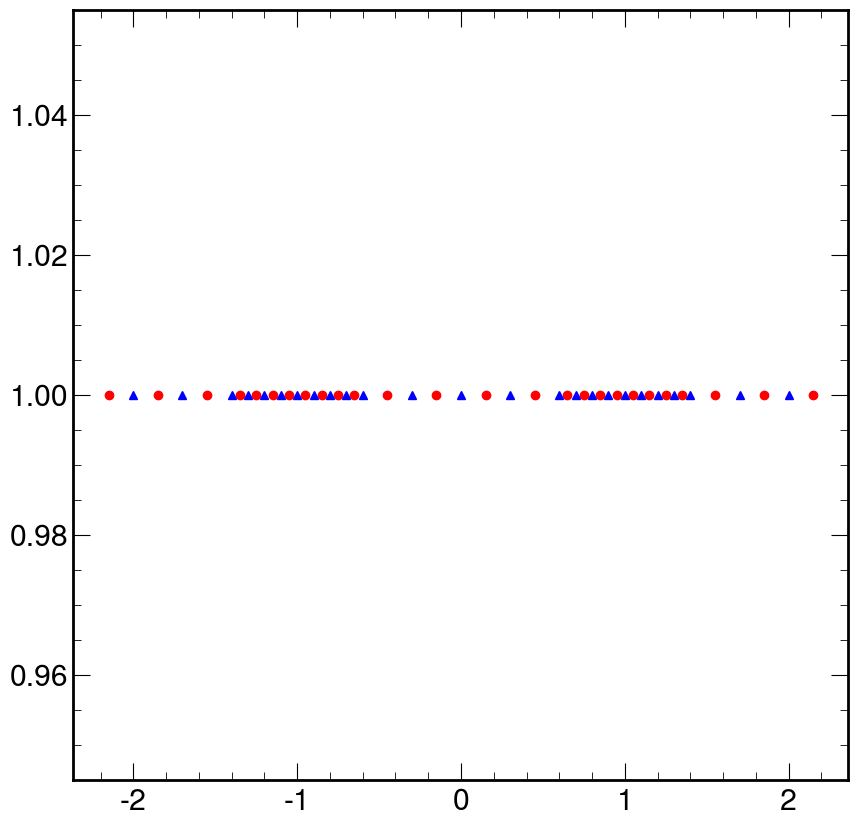

In [4]:
fig, axes = plt.subplots()
axes.plot(
    kW_bin_edges, np.ones(kW_bin_edges.shape), "ro"
)
axes.plot(
    kW_values, np.ones(kW_values.shape), "b^"
)

In [5]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

def colorbar(mappable):
    ax = mappable.axes
    fig = ax.figure
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    return fig.colorbar(mappable, cax=cax)

In [6]:
r_eq_1_sigmas.reshape(np.unique(kW_points).shape[0], np.unique(kZ_points).shape[0])

array([[0.00000000e+00, 4.28753853e-01, 1.70437980e+00, 2.26727748e+00,
        2.86076665e+00, 3.46321845e+00, 4.06032085e+00, 4.64287806e+00,
        5.20640230e+00, 5.74884796e+00, 6.26897430e+00, 7.70322514e+00,
        8.96869278e+00, 4.28753853e-01, 1.70437980e+00, 2.26727748e+00,
        2.86076665e+00, 3.46321845e+00, 4.06003094e+00, 4.64287806e+00,
        5.20640230e+00, 5.74884796e+00, 6.26897430e+00, 7.70322514e+00,
        8.96869278e+00],
       [4.35111195e-01, 1.71320379e+00, 3.47174072e+00, 4.06843519e+00,
        4.65080547e+00, 5.21386147e+00, 8.98988342e+00, 6.27575397e+00,
        6.77385521e+00, 8.98988342e+00, 7.70878601e+00, 8.97356224e+00,
        9.57962036e+00, 1.72730291e+00, 3.48449683e+00, 5.22423840e+00,
        5.76526356e+00, 6.28464317e+00, 6.78229713e+00, 7.25918388e+00,
        7.71614647e+00, 8.15446186e+00, 8.57538795e+00, 8.97978687e+00,
        1.01045256e+01],
       [1.11154776e+01, 2.29619074e+00, 4.08519840e+00, 5.76905870e+00,
        6.2880

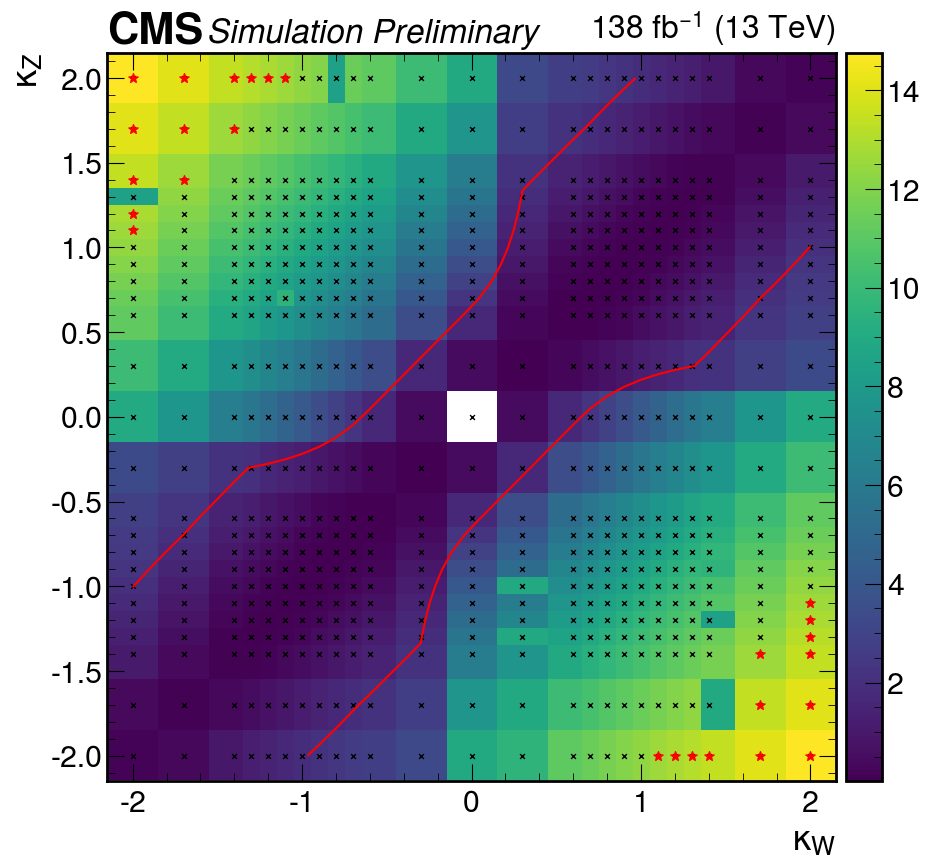

In [7]:
hist2d = yahist.Hist2D(
    (kW_points, kZ_points),
    bins=[kW_bin_edges, kZ_bin_edges],
    weights=np.array(r_eq_1_sigmas)
)

# Plot 2D hist
fig, axes = plt.subplots()
mpl_objs = hist2d.plot(ax=axes, colorbar=False);
# mpl_objs = hist2d.plot(ax=axes, colorbar=False, counts=True, counts_formatter="{:.1f}".format, counts_fontsize=6);
axes.set_xlabel(r"$\kappa_W$");
axes.set_ylabel(r"$\kappa_Z$");
axes.set_aspect("equal");

# Plot (kW, kZ) points where sigma is taken directly from log-likelihood plot
axes.scatter(kW_points, kZ_points, marker="x", color="k", linewidths=1, s=12)
# Plot (kW, kZ) points where sigma is inferred from log-likelihood plot
axes.scatter(kW_spec_points, kZ_spec_points, marker="*", color="r", s=48)

# Plot colorbar
colorbar(mpl_objs[0]);

# Plot contour(s)
axes.contour(
    np.unique(kW_points), np.unique(kZ_points), 
    hist2d.counts,
    [2],
    colors=["r"]
)

# Add CMS label
hep.cms.label(
    "Preliminary",
    data=False,
    lumi=138,
    loc=0,
    ax=axes,
    fontsize=24
);

In [8]:
r_eq_1_sigmas[((kW_points == -1) & (kZ_points == 1))]

array([8.98988342])

In [9]:
r_eq_1_sigmas[((kW_points == -1) & (kZ_points == -1))]

array([0.03397122])

In [10]:
def curve_neg(data, A, B, C):
    x = data[:,0]
    y = data[:,1]
#     return A*(x - y)**2 + B
#     return A*(x - y)**2 + B*(x + y)**2 + C
#     return A*(x - y)**4 + B*(x + y)**4 + C
#     return np.abs(A*(x - y)**2 + B*(x + y)**2 + C)
    return np.sqrt(np.abs(A*(x - y)**2 + B*(x + y)**2 + C))
#     return A*x**2 + B*y**2 + C

def curve_pos(data, A, B):
    x = data[:,0]
    y = data[:,1]
#     return A*(x - y)**2 + B
#     return A*np.sqrt(np.abs(x - y))
    return A*(x - y)**2 + B
#     return A*(x - y)**2 + B*(x + y)**2 + C
#     return A*(x - y)**4 + B*(x + y)**4 + C
#     return np.abs(A*(x - y)**2 + B*(x + y)**2 + C)
#     return np.sqrt(np.abs(A*(x - y)**2 + B*(x + y)**2 + C))
#     return A*x**2 + B*y**2 + C

all_pos = (kW_points*kZ_points > 0)
all_neg = (kW_points*kZ_points <= 0)

opt_params_neg, _ = curve_fit(curve_neg, np.array(list(zip(kW_points[all_neg], kZ_points[all_neg]))), r_eq_1_sigmas[all_neg])
opt_params_pos, _ = curve_fit(curve_pos, np.array(list(zip(kW_points[all_pos], kZ_points[all_pos]))), r_eq_1_sigmas[all_pos])

In [11]:
opt_params_neg

array([1.78425952e+01, 1.60705094e+00, 2.13024270e-07])

In [12]:
opt_params_pos

array([1.41953019, 0.26407079])

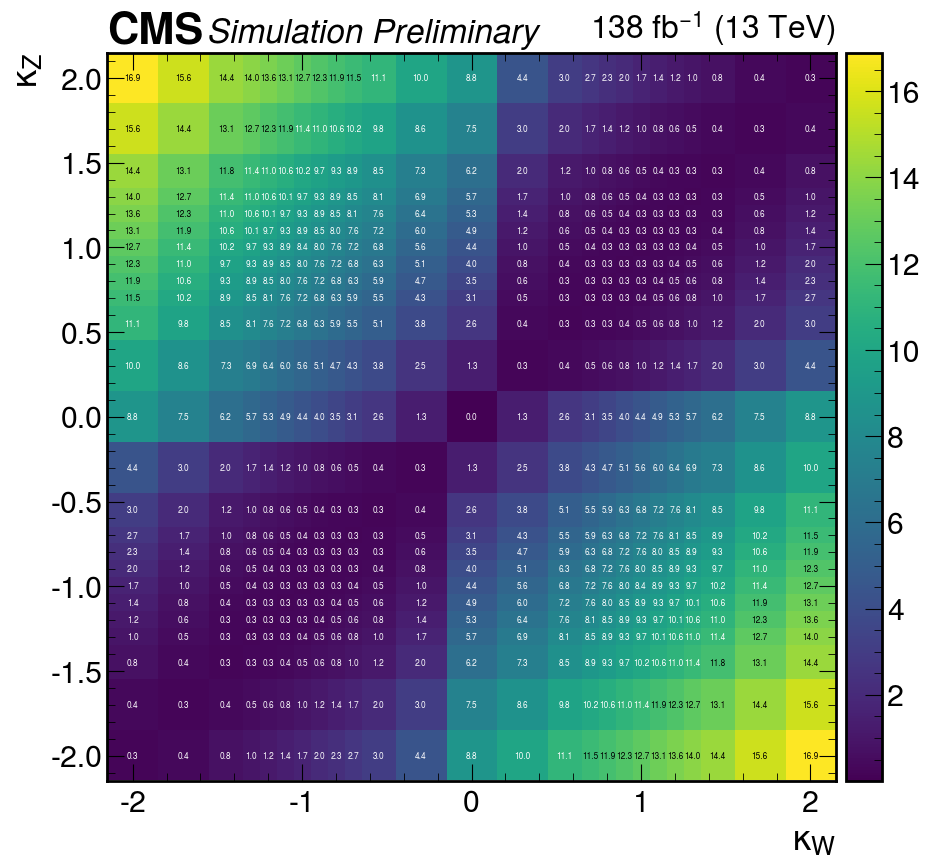

In [13]:
hist2d = yahist.Hist2D(
    (kW_points[all_neg], kZ_points[all_neg]),
    bins=[kW_bin_edges, kZ_bin_edges],
    weights=(
        curve_neg(np.array(list(zip(kW_points[all_neg], kZ_points[all_neg]))), *opt_params_neg)
    )
)
hist2d += yahist.Hist2D(
    (kW_points[all_pos], kZ_points[all_pos]),
    bins=[kW_bin_edges, kZ_bin_edges],
    weights=(
        curve_pos(np.array(list(zip(kW_points[all_pos], kZ_points[all_pos]))), *opt_params_pos)
    )
)

# Plot 2D hist
fig, axes = plt.subplots()
mpl_objs = hist2d.plot(ax=axes, colorbar=False, counts=True, counts_formatter="{:.1f}".format, counts_fontsize=6);
axes.set_xlabel(r"$\kappa_W$");
axes.set_ylabel(r"$\kappa_Z$");
axes.set_aspect("equal");

# Plot colorbar
colorbar(mpl_objs[0]);

# Add CMS label
hep.cms.label(
    "Preliminary",
    data=False,
    lumi=138,
    loc=0,
    ax=axes,
    fontsize=24
);

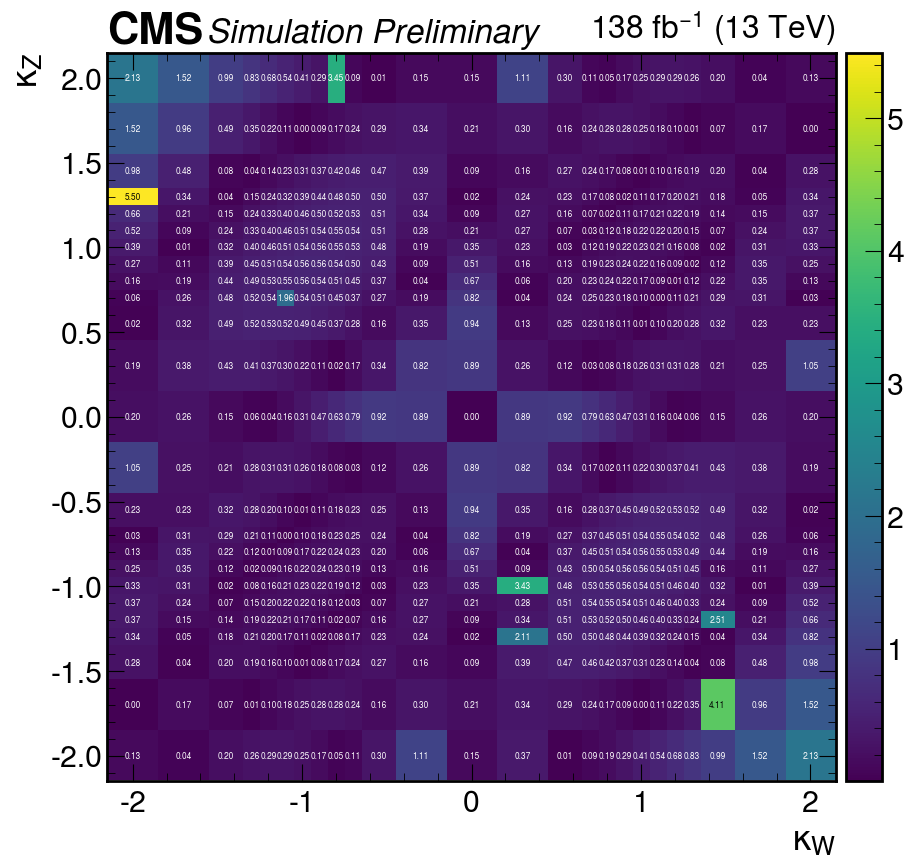

In [14]:
hist2d = yahist.Hist2D(
    (kW_points[all_neg], kZ_points[all_neg]),
    bins=[kW_bin_edges, kZ_bin_edges],
    weights=np.abs(
        curve_neg(np.array(list(zip(kW_points[all_neg], kZ_points[all_neg]))), *opt_params_neg)
        - r_eq_1_sigmas[all_neg]
    )
)
hist2d += yahist.Hist2D(
    (kW_points[all_pos], kZ_points[all_pos]),
    bins=[kW_bin_edges, kZ_bin_edges],
    weights=np.abs(
        curve_pos(np.array(list(zip(kW_points[all_pos], kZ_points[all_pos]))), *opt_params_pos)
        - r_eq_1_sigmas[all_pos]
    )
)

# Plot 2D hist
fig, axes = plt.subplots()
mpl_objs = hist2d.plot(ax=axes, colorbar=False, counts=True, counts_formatter="{:.2f}".format, counts_fontsize=6);
axes.set_xlabel(r"$\kappa_W$");
axes.set_ylabel(r"$\kappa_Z$");
axes.set_aspect("equal");

# Plot colorbar
colorbar(mpl_objs[0]);

# Add CMS label
hep.cms.label(
    "Preliminary",
    data=False,
    lumi=138,
    loc=0,
    ax=axes,
    fontsize=24
);

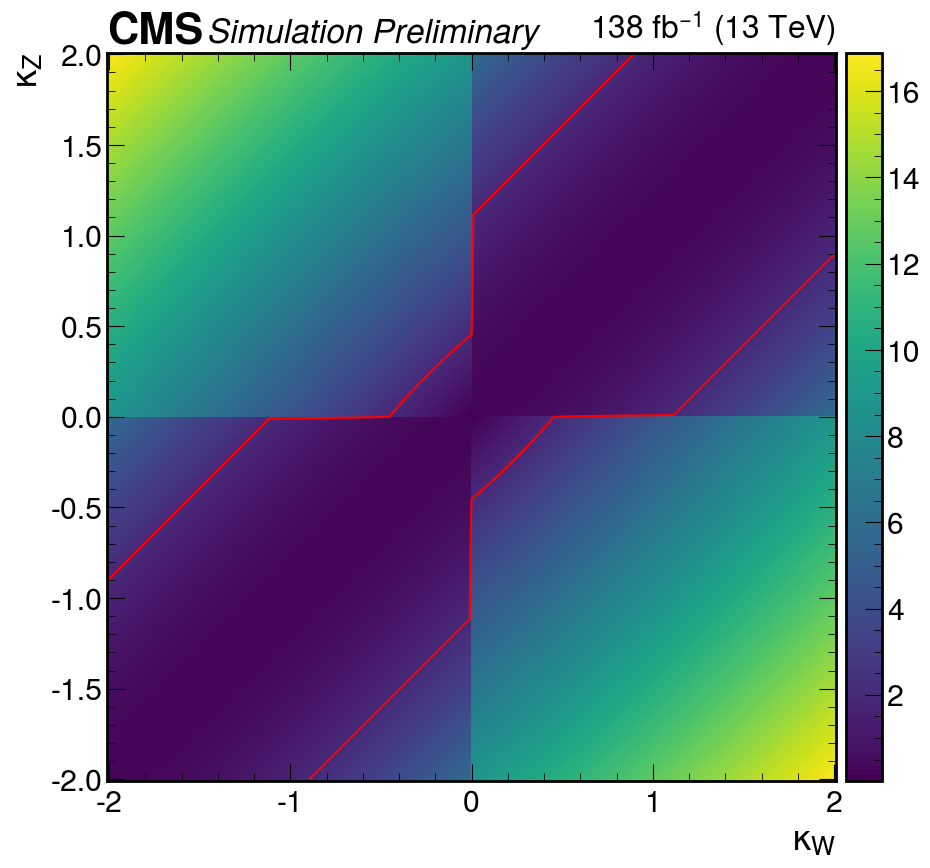

In [15]:
kmin = -2
kmax = 2
kpnts = 401

kW_fine = np.tile(
    np.linspace(kmin, kmax, kpnts), (kpnts, 1)
).T.flatten()
kZ_fine = np.tile(
    np.linspace(kmin, kmax, kpnts), (kpnts, 1)
).flatten()

kW_bin_edges_fine = np.linspace(-2 - (kmax - kmin)/(kpnts - 1), 2 + (kmax - kmin)/(kpnts - 1), kpnts+1)
kZ_bin_edges_fine = np.linspace(-2 - (kmax - kmin)/(kpnts - 1), 2 + (kmax - kmin)/(kpnts - 1), kpnts+1)

all_pos_fine = (kW_fine*kZ_fine > 0)
all_neg_fine = (kW_fine*kZ_fine <= 0)

hist2d = yahist.Hist2D(
    (kW_fine[all_neg_fine], kZ_fine[all_neg_fine]),
    bins=[kW_bin_edges_fine, kZ_bin_edges_fine],
    weights=(
        curve_neg(np.array(list(zip(kW_fine[all_neg_fine], kZ_fine[all_neg_fine]))), *opt_params_neg)
    )
)
hist2d += yahist.Hist2D(
    (kW_fine[all_pos_fine], kZ_fine[all_pos_fine]),
    bins=[kW_bin_edges_fine, kZ_bin_edges_fine],
    weights=(
        curve_pos(np.array(list(zip(kW_fine[all_pos_fine], kZ_fine[all_pos_fine]))), *opt_params_pos)
    )
)

# Plot 2D hist
fig, axes = plt.subplots()
mpl_objs = hist2d.plot(ax=axes, colorbar=False);
axes.set_xlabel(r"$\kappa_W$");
axes.set_ylabel(r"$\kappa_Z$");
axes.set_aspect("equal");

# Plot colorbar
colorbar(mpl_objs[0]);

# Plot contour(s)
axes.contour(
    np.unique(kW_fine), np.unique(kZ_fine), 
    hist2d.counts,
    [2],
    colors=["r"]
)

# Add CMS label
hep.cms.label(
    "Preliminary",
    data=False,
    lumi=138,
    loc=0,
    ax=axes,
    fontsize=24
);

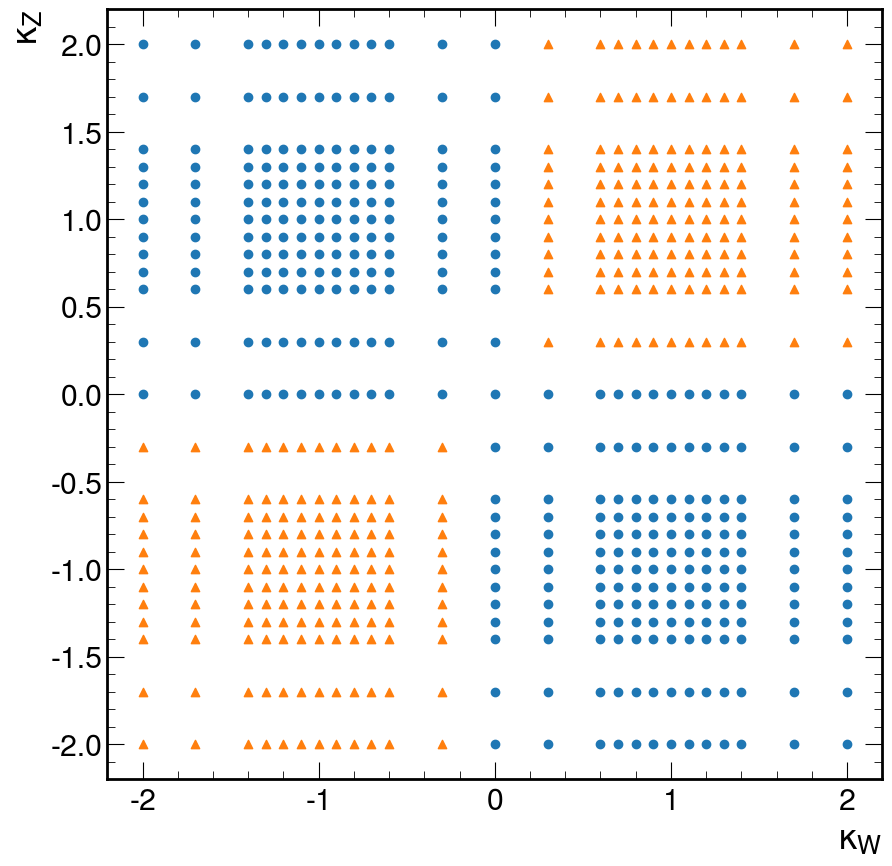

In [16]:
fig, axes = plt.subplots()
axes.scatter(
    kW_points[all_neg], kZ_points[all_neg], marker="o"
)
axes.scatter(
    kW_points[all_pos], kZ_points[all_pos], marker="^"
)
axes.set_xlabel(r"$\kappa_W$");
axes.set_ylabel(r"$\kappa_Z$");